<style>
  .container {
    width: 110% !important;
  }
</style>

# Task 1: Reinforcement learning on the FrozenLake environment


## Description of Frozen Lake Game Elements

#### **Observations**

There are 100 states in FrozenLake-v1, with the observation space representing the agent's location on a 10x10 grid. An integer between 0 and 99 corresponds to a particular tile on the grid and is used to identify each state. Observations give crucial information about the agent's position in the environment. This knowledge is vital for the agent to avoid obstacles like holes and plan actions to reach the goal. In every action, the agent updates the observations to reflect its new position in the grid, underscoring the importance of this information in decision-making.

#### **Action Space**

Four distinct actions denoting a direction—0 for left, 1 for down, 2 for right, and 3 for up—make up the action space in FrozenLake-v1. The agent can move through the grid toward the objective with these actions. However, the environment is not always predictable due to the presence of slick tiles. For example, the agent may glide to an adjacent tile instead of sliding to the precise tile that the selected action intended. This unpredictability adds a layer of challenge and realism to the simulation, requiring the agent to adjust to sudden changes, simulating real-world difficulties.

#### **Rewards**

In this setting, rewards are sparse and binary, which means they are only offered in certain circumstances. For most moves, including falling into holes and moving to ordinary tiles, the agent is rewarded with 0. However, the main focus of this incentive system is the reward of 1 that the agent receives only when it successfully completes the assignment and reaches the target (chest). This reward system plays a crucial role in motivating the agent to stay clear of obstacles and pointless movements, and to concentrate on reaching the destination quickly. It is this system that guides the agent's learning process.

#### **Environment's Info Dictionary**

The info dictionary provides additional information on every stage of the agent's trip through the environment. It might, for instance, provide details about the tiles next to the agent and their precise location within the grid. This information is not necessary for the agent to make decisions, but it helps comprehend the dynamics of the environment. Analysts and developers frequently use this data to evaluate and debug the agent's performance or gain insights into its learning process. For example, they might use it to understand why the agent made a particular decision or to identify patterns in its behaviour.

#### **Episode**

In the context of reinforcement learning, an episode is a single, independent effort in which the agent begins in a fixed location and moves across the grid until it lands in a hole or reaches the goal. After reaching the objective or failing by falling into a hole, each episode comes to a conclusion, and the environment is reset for a fresh try. The agent can learn from repeated experiences thanks to the episode structure, which optimizes its course based on accumulated knowledge. Because there are only a few steps in each episode, efficiency is encouraged, and the agent must gradually improve its approach to accomplish the objective continuously.


# Random Deep Q Learning

## Implementation Explanation

The deployment of the Deep Q-Network (DQN) agent to solve the FrozenLake-v1 environment combines essential reinforcement learning techniques and principled design choices to balance learning efficiency and performance stability. Below, we describe each aspect of the deployment process, the motivations behind the decisions, and the adjustments made to key parameters.

#### 1. **Environment Setup**:
   - **FrozenLake-v1** is a grid-world environment where the agent starts on a "safe" tile and must navigate to a goal tile. The agent must avoid "hole" tiles (where it falls and loses the episode) and slippery surfaces, making the environment stochastic and challenging. The environment was initialized with `is_slippery=True`, adding randomness to the agent's movements.
   - A random map of size $10 \times 10$ with $30\%$ tiles frozen was generated

  ```python
  from gym.envs.toy_text.frozen_lake import generate_random_map

  # Create the environment with is_slippery=True
  random_map = generate_random_map(size=10, p=0.3)
  env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=True)
  env.reset()
  env.render()

  ```

#### 2. **Agent Design**:
   - **Deep Q-Network (DQN)**:
     - The DQN algorithm was used, which approximates the Q-value function $Q(s, a)$ using a neural network. The agent selects actions that maximize the expected cumulative reward.
     - The network outputs Q-values for all possible actions given a state, enabling the agent to balance exploration (trying new actions) and exploitation (choosing the best-known action).

   - **Replay Memory**:
     - To improve learning stability, a replay buffer stores recent transitions $(state, action, reward, next, done)$.
     - Instead of learning from sequential experiences (which may lead to correlated updates), transitions are sampled randomly, breaking correlations and making the learning process more stable.

      ```python
        # Cyclic buffer of bounded size
        class ReplayMemory(object):
            def __init__(self, capacity):
                self.capacity = capacity
                self.memory = []
                self.position = 0

            def push(self, *args):
                """Saves a transition."""
                if len(self.memory) < self.capacity:
                    self.memory.append(None)
                self.memory[self.position] = Transition(*args)
                self.position = (self.position + 1) % self.capacity

            def sample(self, batch_size):
                return random.sample(self.memory, batch_size)

            def __len__(self):
                return len(self.memory)
      ```

   - **Double DQN**:
     - The Double DQN technique mitigates overestimation of Q-values by using two networks:
       - **Policy Network**: Selects the best action for the next state.
       - **Target Network**: Evaluates the value of the selected action.
     - This separation of action selection and evaluation helps stabilize Q-value updates.

#### 3. **Neural Network Architecture**:
   - The network consists of **five layers**:
     - Four fully connected layers, each with **256 neurons**, followed by **LeakyReLU activations**.
     - A final output layer with dimensions equal to the number of actions in the environment.
   - **Dropout layers (20%)** are included after each hidden layer to prevent overfitting, ensuring the agent generalizes well to unseen states.
   - **Xavier/Glorot Initialization** was used to initialize weights. This method ensures the variance of activations remains consistent across layers, leading to better training stability.

  ```python
      class DQN(nn.Module):
          def __init__(self, state_dim, action_dim):
              super().__init__()

              self.network = nn.Sequential(
                  nn.Linear(state_dim, 256),
                  nn.LeakyReLU(),
                  nn.Dropout(0.2),

                  nn.Linear(256, 256),
                  nn.LeakyReLU(),
                  nn.Dropout(0.2),

                  nn.Linear(256, 256),
                  nn.LeakyReLU(),
                  nn.Dropout(0.2),

                  nn.Linear(256, 256),
                  nn.LeakyReLU(),
                  nn.Dropout(0.2),

                  nn.Linear(256, action_dim)
              )

              # Initialize weights using Xavier/Glorot initialization
              for m in self.modules():
                  if isinstance(m, nn.Linear):
                      nn.init.xavier_uniform_(m.weight)
                      nn.init.constant_(m.bias, 0)

          def forward(self, x):
              return self.network(x)
```

#### 4. **Training Strategy**:
   - **Exploration-Exploitation Trade-off**:
     - Initially, the agent explores heavily $(\epsilon = 1.0)$ to gather diverse experiences.
     - Over time, exploration decreases $\epsilon$ decays exponentially to 0.1, allowing the agent to exploit its learned policy.
   - **Reward Function**:
     - Rewards are assigned based on the environment’s feedback, with adjustments for intermediate states to encourage exploration. Which are basically defined as 1 if the agent reaches the goal otherwise it is 0.
   - **Experience Replay**:
     - Training occurs every 5 episodes (train frequency) using batches of 64 transitions sampled from the replay buffer.
   - **Target Network Updates**:
     - The target network is updated every 5 episodes to provide stable Q-value targets for the policy network.
   - **Optimization**:
     - The AdamW optimizer with weight decay (1e-5) was used to penalize large weight values and prevent overfitting.


#### 5. **Hyperparameters**:

| **Hyperparameter**       | **Value**       | **Description**                                                                                                                                                   | **Reason for Choice**                                                                                                                                                                   |
|---------------------------|-----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_episodes`          | 100,000          | Total number of training episodes.                                                                                                                                | Provides sufficient iterations for the agent to explore the environment and converge to an optimal policy.                                                                              |
| `max_steps`               | 500             | Maximum steps allowed per episode.                                                                                                                                | Prevents episodes from running indefinitely and encourages efficient exploration of the environment.                                                                                    |
| `learning_rate`           | 0.0001          | Learning rate for the AdamW optimizer.                                                                                                                            | A small value ensures stable and gradual weight updates, preventing divergence.                                                                                                         |
| `gamma`                   | 0.6             | Discount factor for future rewards.                                                                                                                               | Balances the importance of immediate and future rewards. A moderate value was chosen to encourage the agent to consider both.                                                           |
| `batch_size`              | 64              | Number of samples per batch for training.                                                                                                                         | Provides a balance between computational efficiency and the statistical robustness of updates.                                                                                          |
| `target_update`           | 5               | Frequency (in episodes) at which the target network is updated.                                                                                                   | Helps stabilize training by providing consistent Q-value targets over multiple episodes.                                                                                                |
| `train_frequency`         | 5               | Frequency (in episodes) at which the network is trained.                                                                                                          | Reduces computational overhead and ensures the replay buffer contains diverse transitions before training.                                                                               |
| `train_epochs`            | 1               | Number of epochs per training update.                                                                                                                             | Limits overfitting during each training update, allowing gradual learning.                                                                                                              |
| `epsilon`                 | 1.0             | Initial exploration rate.                                                                                                                                         | A high value ensures maximum exploration at the start of training when the policy is unoptimized.                                                                                       |
| `max_epsilon`             | 1.0             | Maximum value of epsilon (exploration rate).                                                                                                                      | Ensures sufficient exploration at the beginning of training.                                                                                                                            |
| `min_epsilon`             | 0.1             | Minimum value of epsilon (exploration rate).                                                                                                                      | Ensures exploitation of the learned policy as training progresses.                                                                                                                      |
| `decay_rate`              | 0.0001          | Rate of exponential decay for epsilon.                                                                                                                            | Smoothly reduces exploration over time, encouraging the agent to exploit its learned policy while still exploring occasionally.                                                         |
| `memory_capacity`         | 500,000         | Capacity of the replay memory buffer.                                                                                                                             | Ensures that the agent has access to a large history of transitions, enabling diverse training samples.                                                                                  |
| `dropout_rate`            | 0.2             | Dropout probability for the neural network.                                                                                                                       | Regularization to prevent overfitting and encourage robustness in the policy.                                                                                                           |
| `weight_decay`            | 0.00001         | L2 regularization parameter for the optimizer.                                                                                                                    | Penalizes large weight values, encouraging simpler models and preventing overfitting.                                                                                                   |

#### 6. **Adjustments and Design Choices**

1. **Exploration Parameters**:
   - A high initial exploration rate $(\epsilon = 1.0)$ was chosen to ensure the agent explores the entire environment early in training.
   - Epsilon decays gradually with a small decay rate (0.0001), allowing the agent to focus on exploitation only after sufficient exploration.

2. **Learning Rate**:
   - A small learning rate (0.0001) ensures that weight updates are small, preventing instability in the learning process.

3. **Replay Buffer**:
   - A large capacity (500,000) was chosen to ensure the replay buffer could store diverse experiences, allowing the agent to learn from various state-action pairs.

4. **Neural Network Architecture**:
   - LeakyReLU activations were chosen to prevent the "dying ReLU" problem, where neurons become inactive during training.
   - Dropout and weight decay were added to prevent overfitting, ensuring the network generalizes well to unseen states.

5. **Target Update Frequency**:
   - Updating the target network every 5 episodes reduces instability in Q-value targets, providing smoother learning.

6. **Number of Episodes**:
   - Finding the right number of episodes is critical as it defines the number of training instances.

## Training Explanation

Below we will breakedown the training of the DQN network and the roles of key elements within the function:

### **1. Collecting Training Instances**
- A `for` loop iterates through a specified number of episodes (`total_episodes`), representing independent trials in the environment. Each episode is an attempt by the agent to learn by interacting with the environment.
- At the beginning of each episode, the environment is reset to obtain the starting state (`current_state`).

```python
for episode in tqdm(range(1, total_episodes + 1)):
    current_state, _ = env.reset()
```

- The initial state is one-hot encoded to represent it in a way suitable for the neural network, and then it is converted into a PyTorch tensor to be processed on the device.

```python
    state = one_hot_encode(current_state, nspace)
    state = torch.tensor(np.array([state]), device=device)
```

- Variables like `total_rewards`, `actual_rewards`, and `total_steps` are reset for tracking progress within the episode.

```python
    total_rewards = 0
    actual_rewards = 0
    total_steps = 0
    visited_states = set()
    visited_states.add(current_state)
```

- The agent interacts with the environment in a series of steps (up to a maximum defined by `max_steps`).

```python
    for step in range(max_steps):
```


### **2. Action Selection (`get_action` function)**

- With probability \( \epsilon \), the agent selects a random action (exploration), while with probability \( 1 - \epsilon \), it selects the action with the highest Q-value from the policy network (exploitation).

```python
def get_action(state, epsilon):
    exp_exp_tradeoff = random.uniform(0, 1)
    if exp_exp_tradeoff > epsilon:
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)  # Exploitation
    else:
        action = env.action_space.sample()  # Exploration
        action = torch.tensor(np.array(action), device=device).view(1, 1)
    return action
```

- For each step, the agent chooses an action based on an epsilon-greedy policy, which balances exploration and exploitation.

```python
  action = get_action(state, epsilon)
```

### **3. Environment Interaction**
- The chosen action is executed in the environment, and the agent receives feedback in the form of `next_state`, `org_reward`, `done` (indicating if the episode has ended), and other metadata.

```python
  next_state, org_reward, done, t, prob = env.step(action.item())
```

- The environment’s reward (`org_reward`) is potentially sparse, so an adjusted reward is calculated based on specific criteria (here, it remains the same as `org_reward`).

```python
  reward = torch.tensor(np.array([org_reward]), device=device)
```

- The transition `(state, action, next_state, reward, done)` is stored in the replay memory buffer. This buffer enables experience replay, which stabilizes training by breaking correlations between consecutive experiences.

```python
  memory.push(state, action, next_state, reward, done)
```

- The agent updates its current state to `next_state` for the next iteration. If the episode ends (`done` is `True`), the loop breaks early.

```python
  state = next_state
  if done:
      break
```

### **4. Training the Network**
- Every `train_frequency` episodes, if there are enough samples in the replay buffer, the agent trains on batches of transitions.

```python
if episode % train_frequency == 0 and len(memory) >= batch_size:
    for _ in range(train_epochs):
        transitions = memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
```

- **State-Action Q-value Calculation**: The policy network computes Q-values for the actions taken in the batch.

```python
      state_batch = torch.cat(batch.state)
      action_batch = torch.cat(batch.action)
      state_action_values = policy_net(state_batch).gather(1, action_batch)
```

- **Target Q-value Calculation (Double DQN)**:
  - The policy network selects the best actions for the `next_state_batch`, while the target network evaluates their Q-values.

```python
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    done_batch = torch.cat(batch.done)

    with torch.no_grad():
        next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)
        next_state_values = target_net(next_state_batch).gather(1, next_actions).squeeze()
```

  - The target Q-values are computed.

```python
  target_q_values = (next_state_values * (1 - done_batch) * gamma) + reward_batch
```

- **Loss Calculation and Backpropagation**: The Smooth L1 loss (Huber loss) is calculated between the predicted Q-values and the target Q-values, and the optimizer updates the policy network’s parameters.

```python
    loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

### **5. Target Network Update**
- Every `target_update` episodes, the target network is synchronized with the policy network’s parameters. This provides stable targets for Q-learning.

```python
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
```

- At the end of each episode, epsilon is decayed according to the exponential decay formula to encourage more exploitation over time.

```python
    epsilon = max(min_epsilon, epsilon * (1 - decay_rate))
```


## Results

### **Evaluation**

#### **1. Reward at Each Episode**:
- The reward plot demonstrates that the rewards per episode remain close to zero for most of the training process.
- This flat trend indicates that the agent rarely reaches the goal, failing to collect significant rewards.
- The environment's sparse reward structure (reward = 1 only upon reaching the goal) heavily impacts the agent's learning process, as it receives minimal feedback to guide policy improvements.
- The agent's inability to achieve the goal consistently can also be attributed to the stochastic nature of the FrozenLake environment, where unpredictable movements hinder optimal decision-making.

   ```python
   # Plot Reward at Each Episode
   plt.plot(rewards)
   plt.xlabel('Episode')
   plt.ylabel('Reward')
   plt.title('Reward at Each Episode')
   plt.show()
   ```

#### **2. Steps Moved at Each Episode**:
- The number of steps moved per episode fluctuates significantly, showing no clear upward or downward trend throughout the training process.
- This variability highlights the agent’s attempt to explore various paths in the environment, which is crucial during early learning.
- However, the lack of convergence toward an optimal policy suggests that the agent is not learning a consistent strategy to reach the goal effectively.

   ```python
   # Plot Steps Moved at Each Episode
   plt.plot(steps_moved)
   plt.xlabel('Episode')
   plt.ylabel('Steps Moved')
   plt.title('Steps Moved at Each Episode')
   plt.show()
   ```

#### **3. Moving Averages of Reward and Steps**:
- The moving average of rewards remains near zero throughout the training process, confirming that the agent fails to improve its policy over time.
- This trend is a direct consequence of the environment's sparse rewards and the agent's challenges in handling the randomness of slippery tiles.
- The moving average of steps moved shows minor variations but does not indicate meaningful progress in learning a robust policy.
- These observations collectively suggest that while the agent is actively exploring the environment, it struggles to exploit learned strategies effectively.

   ```python
   # Plot Moving Average of Rewards
   moving_average_rewards = np.convolve(rewards, np.ones(1000) / 1000, mode='valid')
   plt.plot(moving_average_rewards)
   plt.xlabel('Episode')
   plt.ylabel('Reward (Moving Average)')
   plt.title('Reward (Moving Average)')
   plt.show()

   # Plot Moving Average of Steps Moved
   moving_average_steps = np.convolve(steps_moved, np.ones(1000) / 1000, mode='valid')
   plt.plot(moving_average_steps)
   plt.xlabel('Episode')
   plt.ylabel('Steps Moved (Moving Average)')
   plt.title('Steps Moved (Moving Average)')
   plt.show()
   ```

##### Results for 10x10 using Random Deep Q Learning

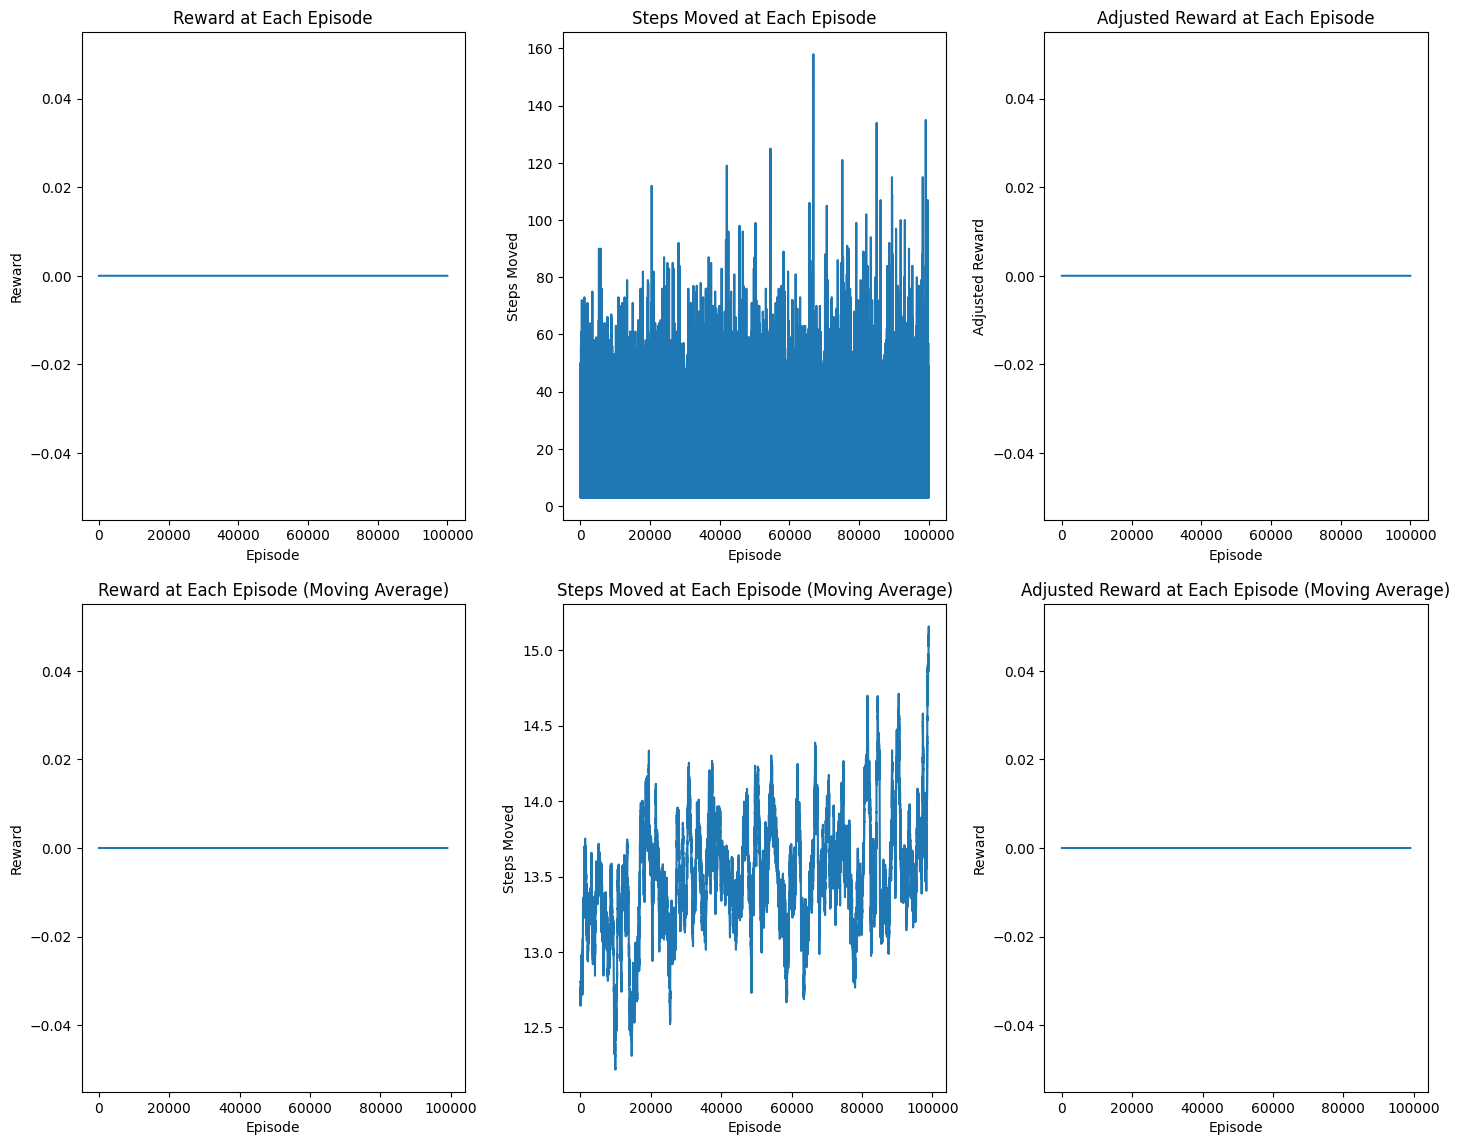

### **Discussion**

#### **Insights from Experimentation**:
- The model demonstrates some ability to learn and avoid falling into holes as training progresses.
- However, the stochasticity of the environment and the absence of intermediate rewards hinder the agent's ability to develop a consistent policy for reaching the goal.
- This setup works reasonably well for smaller grid sizes, where the state space is limited, and the agent can explore effectively within computational constraints.

#### **Challenges**:
- **Stochastic Environment**:  
  - The "slippery" characteristic of FrozenLake introduces significant randomness to the agent’s movements.
  - This unpredictability makes it challenging for the agent to learn deterministic state-action relationships and devise a reliable strategy.
- **Sparse Rewards**:  
  - The environment provides rewards only upon reaching the goal, offering little to no incremental feedback for actions leading toward the goal.
  - This sparse reward system slows down the learning process, as the agent struggles to distinguish between effective and ineffective actions.
- **Exploration vs. Exploitation**:  
  - While the epsilon-greedy policy initially promotes extensive exploration, the gradual decay of epsilon may lead to over-exploration due to the large number of episodes.
  - As a result, the agent does not fully transition to exploiting learned strategies, especially in the absence of consistent rewards.

#### **Key Observations**:
1. **Avoidance Behavior**:  
   - As training progresses, the agent increasingly learns to avoid tiles that lead to holes, indicating that it is learning to identify negative rewards and avoid repeating actions that lead to failure.
2. **Limited Goal Achievement**:  
   - Despite avoiding holes, the agent struggles to consistently reach the goal due to the stochastic nature of the FrozenLake environment.
   - The randomness in movement disrupts the agent's planned actions, reducing its chances of success.

### **Causes for Failure**
1. **Sparse Rewards**:
   - The lack of incremental rewards for progress makes it harder for the agent to associate actions with long-term benefits.
   - Without intermediate feedback, the agent cannot learn step-by-step strategies that lead to the goal.
2. **Computational Constraints**:
   - Due to limited computational resources, the agent cannot explore the state space exhaustively in larger grid sizes, leading to suboptimal policy convergence.
3. **Random Exploration**:
   - The random exploration strategy employed during training sets the agent up for failure, especially in larger and more stochastic environments.
   - This random approach results in inefficient learning, as the agent spends significant time exploring unproductive paths.

### **How we would improve it**
1. **Reward Shaping**:
   - Introduce intermediate rewards for actions that lead closer to the goal. For example:
     - Positive rewards for moving closer to the goal.
     - Negative rewards for moving away from the goal or revisiting previously visited states.
2. **Directed Exploration**:
   - Replace random exploration with more effective strategies, such as:
     - **Prioritized Experience Replay**: Sampling transitions with higher temporal difference (TD) errors to learn from more impactful experiences.
     - **Curiosity-Driven Exploration**: Encouraging the agent to explore less-visited states using using informed steps.
3. **Improved Policy Framework**:
   - Using simpler but more efficent reinforcement learning techniques such as:
     - **Q Learning**:
        - Q-Learning is a value-based reinforcement learning algorithm that directly updates the Q-values for each state-action pair without requiring a neural network approximation.
        - This simplicity can be beneficial for environments like FrozenLake, where the state and action spaces are not extensive and do not demand the complexities of a Deep Q learning.


# Informed Q-Learning

Informed Q-Learning is an enhancement of the traditional Q-Learning algorithm designed to address challenges such as sparse rewards, stochastic environments, and inefficiencies in state exploration. By integrating heuristic guidance, reward shaping, and explicit handling of randomness, the agent gains more structured feedback and guidance, enabling it to learn more effectively in environments like FrozenLake.

Our implementation leverages the following key enhancements:

- A Manhattan distance heuristic for goal-oriented action selection.
- Reward understanding to mitigate the sparse reward problem by providing intermediate feedback for progress.
- Adjustments for slippery tiles, ensuring robustness in stochastic environments.
- Penalties for repetitive state visits, encouraging diverse exploration.


## **Training Explanation**

#### **1. Q-Table Initialization**
- The Q-table is initialized as a zero matrix of dimensions $(\text{number of states}, \text{number of actions})$, representing the agent's initial lack of knowledge about the environment.
  - $ Q(s, a) = 0 \quad \forall s, a $.
- Starting with zero ensures that the agent relies purely on exploration during the initial episodes to gather diverse experiences and learn the value of different state-action pairs.

#### **2. Exploration vs. Exploitation (Epsilon-Greedy Policy)**
-  The agent uses an epsilon-greedy strategy to balance exploration (trying new actions) and exploitation (choosing the best-known action).
  - At the start of training, the exploration rate $( \epsilon )$ is 1 $( \epsilon = 1.0 )$, ensuring random exploration.
  - Over time, $ \epsilon $ decays exponentially:

    $$
    \epsilon = \max(\epsilon_{\text{min}}, ϵ*(1-\text{decay rate}))
    $$
    
  - Parameters:
    - $ \epsilon_{\text{max}} = 1.0 $: Maximum exploration at the start.
    - $ \epsilon_{\text{min}} = 0.1 $: Minimum exploration toward the end.
    - $ \text{decay rate} = 0.0001 $: Smooth decay over episodes.
  - Early exploration ensures that the agent discovers different paths and avoids prematurely converging to a suboptimal policy.
  - Gradual decay encourages the agent to shift focus to exploiting its learned policy as training progresses, maximizing reward efficiency.

#### **3. Action Selection with Heuristic Guidance**
- During action selection, the Q-values are adjusted based on the Manhattan distance heuristic:
  - The adjusted Q-value used for decision-making is:
    $$
    Q(s, a) - \alpha \cdot d(s + a, g)
    $$
  - Where:
    - $ Q(s, a) $: The learned value of taking action $ a $ at state $ s $.
    - $ d(s + a, g) $: The Manhattan distance from the resulting state to the goal.
    - $ \alpha = 0.1 $: Scaling factor for the heuristic penalty.
  - By incorporating the heuristic, the agent prioritizes actions that align with the shortest path to the goal, even in the absence of immediate rewards.
  - This reduces random wandering and accelerates convergence to an optimal policy.

  ```python
  # Manhattan distance heuristic to guide the agent
  # towards the goal which is at at the end of the grid
  goal_position = env.observation_space.n - 1
  def manhattan_distance(state):
      grid_size = int(np.sqrt(nspace))
      state_x, state_y = state % grid_size, state // grid_size
      goal_x, goal_y = goal_position % grid_size, goal_position // grid_size
      return abs(goal_x - state_x) + abs(goal_y - state_y)

  # Epsilon-greedy policy with heuristic guidance
  def get_action(state, epsilon):
      if random.uniform(0, 1) < epsilon:
          return env.action_space.sample()  # Random exploration
      else:
          heuristic_values = [
              Q_table[state, a] - 0.1 * manhattan_distance(state + a)
              for a in range(naction)
          ]
          return np.argmax(heuristic_values)  # Exploitation with heuristic
  ```

#### **4. Reward Shaping for Sparse Feedback**
-  Sparse rewards (default in FrozenLake) are augmented with intermediate feedback to guide the agent. The total reward for each step is calculated as:
  $$
  r = r_{\text{goal/failure}} + r_{\text{proximity}} + r_{\text{slip}} + r_{\text{revisit}} + r_{\text{risk}}
  $$
  - **Goal/Failure Rewards**:
    - $ r = +10 $ if the agent reaches the goal.
    - $ r = -5 $ if the agent falls into a hole.
  - **Proximity-Based Rewards**:
    - Positive reward $( +0.2 )$ for moving closer to the goal.
    - Small penalty $( -0.1 )$ for moving further away.
  - **Slip Compensation**:
    - Positive reward ($ +0.5 $) if a slip still results in a closer position.
    - Penalty ($ -0.5 $) if a slip leads to a worse position.
  - **Visited State Rewards/Penalties**:
    - Penalty ($ -0.2 $) for redundant revisits.
    - Small reward ($ +0.1 $) for careful revisits near dangerous zones.
  - **Risk-Based Rewards**:
    - Small reward ($ +0.2 $) for avoiding states with multiple adjacent holes.
  - Slipping is accounted for in the reward function, with penalties or rewards based on whether the slip improves or worsens the agent's position relative to the goal.
  - Accounting for slipping explicitly ensures that the agent adapts its policy to handle environmental unpredictability, making it more robust.

  ```python
  action = get_action(state, epsilon)
  intended_action = action
  grid_size = int(np.sqrt(nspace))
  x, y = current_state % grid_size, current_state // grid_size
  if intended_action == 0:  # Left
      expected_next_state = (y * grid_size + max(x - 1, 0))
  elif intended_action == 1:  # Down
      expected_next_state = (min(y + 1, grid_size - 1) * grid_size + x)
  elif intended_action == 2:  # Right
      expected_next_state = (y * grid_size + min(x + 1, grid_size - 1))
  elif intended_action == 3:  # Up
      expected_next_state = (max(y - 1, 0) * grid_size + x)

  next_state, org_reward, done, _, _ = env.step(action)
  reward = 0

  slipped = (next_state != expected_next_state)

  # Reward shaping (adjusted to be cautious around holes)
  if done:
      reward = 10 if org_reward == 1 else -5
  else:
      distance_to_goal = manhattan_distance(current_state)
      next_distance_to_goal = manhattan_distance(next_state)

      # Reward for getting closer to the goal
      if next_distance_to_goal < distance_to_goal:
          reward += 0.2
      elif next_distance_to_goal > distance_to_goal:
          reward -= 0.1

      if slipped:
          if next_distance_to_goal < distance_to_goal:
              reward += 0.5  # Reward self-corrective movement after slipping
          else:
              reward -= 0.5  # Penalize if the slip leads to a worse position

      adjacent_holes = 0
      grid_size = int(np.sqrt(nspace))
      neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]

      for dx, dy in neighbors:
          nx, ny = (current_state % grid_size) + dx, (current_state // grid_size) + dy
          if 0 <= nx < grid_size and 0 <= ny < grid_size:
              neighbor_state = ny * grid_size + nx
              if env.desc[ny][nx] == b'H':  
                  adjacent_holes += 1

      if next_state in visited_states:
          if adjacent_holes == 0:
              reward += 0.2  
          else:
              reward += 0.1
      else:
          if adjacent_holes == 0:
              reward += 0.5  
          else:
              reward += 0.2

      visited_states.add(next_state)

  ```

#### **5. Q-Value Update Rule (Bellman Equation)**
-  The Q-values are updated after each step using the Bellman equation:
  $$
  Q(s, a) = Q(s, a) + \alpha \cdot \big[ r + \gamma \cdot \max_a Q(s', a) - Q(s, a) \big]
  $$
  - Parameters:
    - $ \alpha = 0.1 $: Learning rate, controlling the size of updates to the Q-value.
    - $ \gamma = 0.6 $: Discount factor, balancing the importance of immediate and future rewards.
    - $ r $: Reward received for the current step.
    - Maximum Q-value for the next state, representing the best future action.
  - The update rule ensures that the agent learns from both immediate rewards $( r )$ and expected future rewards.
  - The discount factor $( \gamma )$ encourages the agent to plan ahead, prioritizing actions that lead to long-term success.

```python
old_value = Q_table[state, action]
next_max = np.max(Q_table[next_state])
Q_table[state, action] = old_value + learning_rate * (reward + gamma * next_max - old_value)
```

## **Implementation Explanation**

Below is the table of hyperparameters used in the implementation, along with their descriptions, values, and justifications for the chosen values:

| **Hyperparameter**       | **Value**            | **Description**                                                                                                   | **Reason for Choice**                                                                                                                                   |
|---------------------------|----------------------|-------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Total Episodes**        | 1,400,000           | Total number of training episodes.                                                                                | Provides sufficient iterations for the agent to explore and converge to an optimal policy while balancing exploration and exploitation.                 |
| **Maximum Steps**         | 500                 | Maximum number of steps allowed per episode.                                                                      | Prevents episodes from running indefinitely and encourages efficient exploration of the environment.                                                    |
| **Learning Rate (α)**     | 0.1                 | Step size for updating Q-values during training.                                                                  | A moderate value ensures gradual and stable updates to Q-values, preventing instability while allowing effective learning.                              |
| **Discount Factor (γ)**   | 0.6                 | Weighting of future rewards in the Bellman equation.                                                              | Balances the importance of immediate and future rewards, encouraging the agent to plan ahead without ignoring short-term gains.                         |
| **Epsilon (ε)**           | 1.0 (initial)       | Initial exploration rate for the epsilon-greedy policy.                                                           | Ensures maximum exploration at the start of training to gather diverse experiences and prevent premature convergence to a suboptimal policy.            |
| **Minimum Epsilon (ε_min)** | 0.1               | Minimum exploration rate.                                                                                         | Ensures that the agent retains some level of exploration throughout training to adapt to new states and refine its policy.                              |
| **Decay Rate (ε)**        | 0.0001              | Exponential decay rate for epsilon over episodes.                                                                 | Gradually shifts focus from exploration to exploitation, balancing the two phases effectively during training.                                          |
| **Scaling Factor (α for Heuristic)** | 0.1         | Weight applied to the Manhattan distance heuristic during action selection.                                        | Ensures the heuristic influences the action-selection process without overpowering learned Q-values, maintaining a balance between guidance and learning.|
| **Reward for Goal**       | +10                 | Reward given when the agent successfully reaches the goal.                                                        | Strongly reinforces successful episodes, encouraging the agent to prioritize reaching the goal.                                                        |
| **Penalty for Falling**   | -5                  | Penalty applied when the agent falls into a hole.                                                                 | Discourages risky actions, helping the agent learn to avoid dangerous zones in the environment.                                                         |
| **Proximity Reward**      | +0.2                | Reward for moving closer to the goal (based on Manhattan distance).                                               | Encourages incremental progress toward the goal, particularly in the absence of immediate rewards.                                                     |
| **Proximity Penalty**     | -0.1                | Penalty for moving further from the goal (based on Manhattan distance).                                           | Penalizes inefficient movements, ensuring the agent focuses on goal-directed actions.                                                                   |
| **Slip Reward**           | +0.5                | Reward for slipping closer to the goal.                                                                           | Encourages the agent to adapt to the stochastic nature of the environment and make the best of unpredictable movements.                                  |
| **Slip Penalty**          | -0.5                | Penalty for slipping further from the goal.                                                                       | Discourages careless behavior in slippery regions, promoting cautious navigation.                                                                       |
| **Visited State Penalty** | -0.2                | Penalty for revisiting safe but redundant states.                                                                 | Reduces repetitive behavior, encouraging efficient exploration of the environment.                                                                      |
| **Visited State Reward**  | +0.1                | Reward for revisiting near-danger zones (e.g., holes).                                                            | Recognizes careful and calculated exploration near risky areas, improving adaptability in hazardous zones.                                              |
| **Risk-Based Reward**     | +0.2                | Reward for avoiding states with multiple adjacent holes.                                                          | Promotes safe navigation and reduces the likelihood of falling into holes.                                                                              |                                                                                                                 



## **Results**

### **Evaluation**

#### **1. Reward at Each Episode**
- The **reward per episode** plot indicates a significant sparsity in positive rewards. The agent reaches the goal twice, as evidenced by the flat lines near zero with only sporadic spikes in reward this still as significant improvement from before.
- This demonstrates that the agent struggled to consistently optimize its policy, primarily due to the inherent stochasticity of the environment.
- The lack of consistent goal achievement suggests challenges in adapting to slippery tiles and efficiently navigating the randomized layout.

#### **2. Steps Moved at Each Episode**
- The **steps moved per episode** plot shows substantial fluctuations across episodes, with no clear convergence to an optimal number of steps.
- Initially, the agent explores extensively, but even in later episodes, the variability persists, indicating inefficiencies in the learned policy.
- This variability reflects the agent's inability to consistently plan and execute paths toward the goal due to the stochastic transitions introduced by the slippery tiles.

#### **3. Adjusted Reward at Each Episode**
- The **adjusted reward** plot demonstrates greater variability and range compared to the raw reward plot. This indicates that reward shaping and intermediate feedback provided more granular guidance during training.
- However, the inconsistency in adjusted rewards over episodes highlights the agent's struggle to fully leverage rewards in building a stable, goal-oriented policy.


##### Results for 10x10 using Informed Q Learning

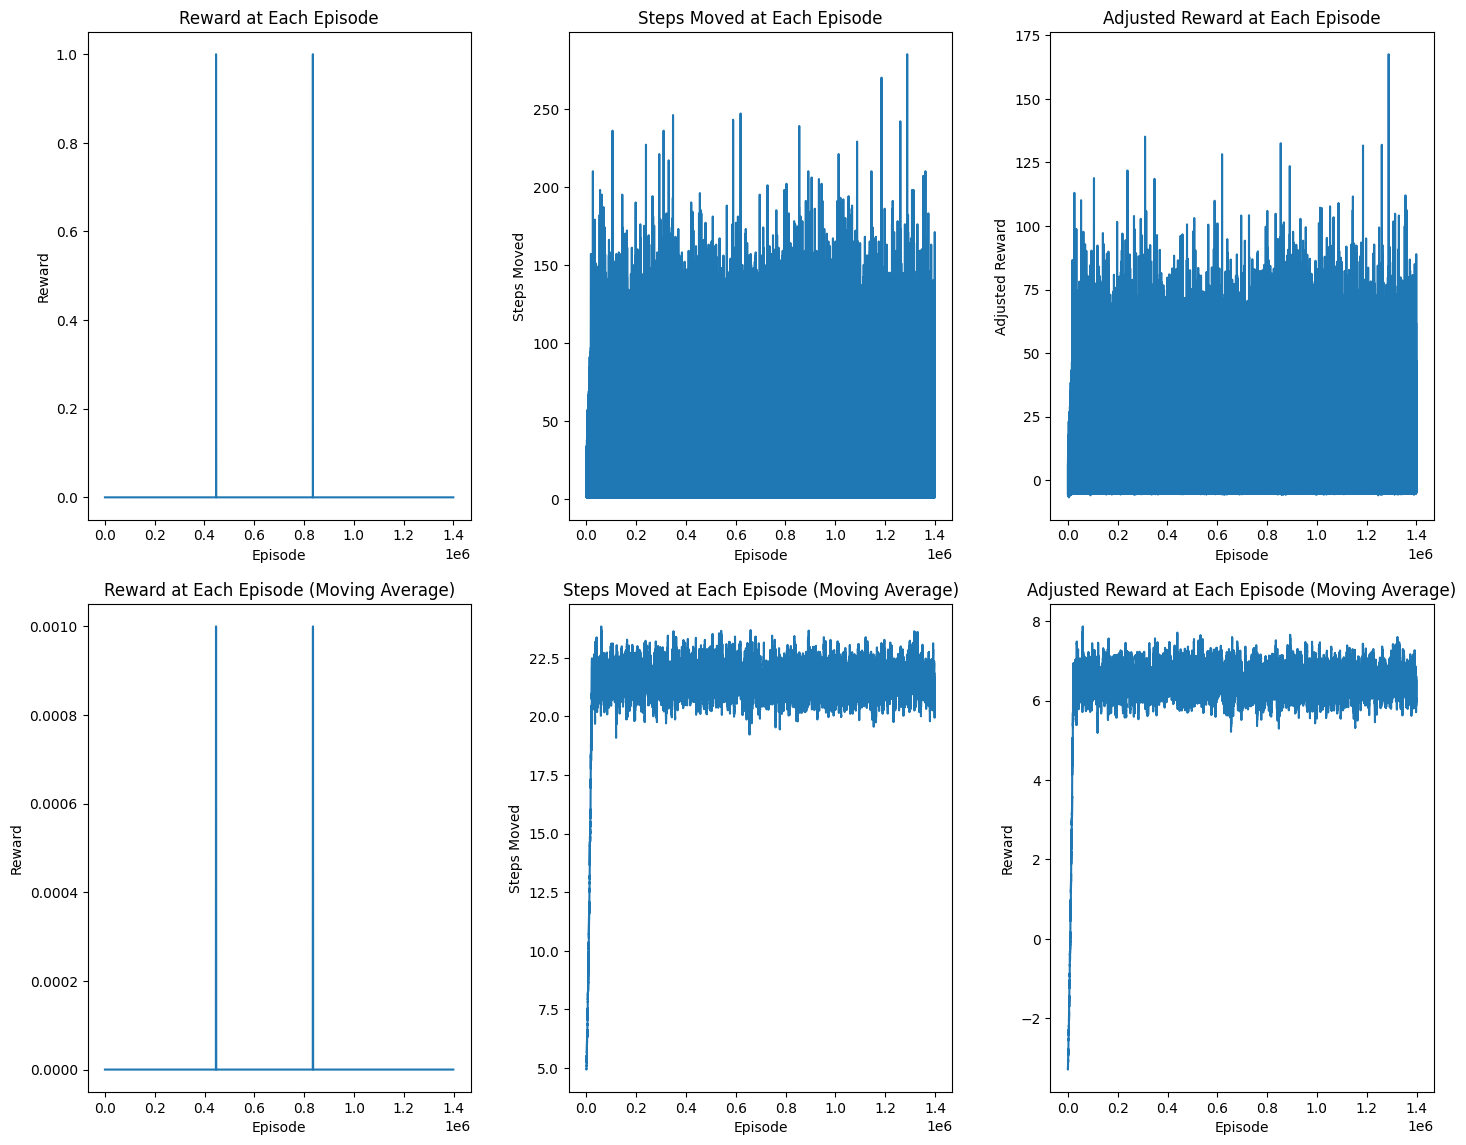

### **Discussion**

#### **Stochastic Environment**
- The **slippery nature of the tiles** introduces substantial randomness, making the outcome of each action highly unpredictable. This increases the noise in the agent's learning process, leading to:
  - Significant variability in steps moved per episode.
  - Inconsistent adjustments to the policy despite shaped rewards and penalties.
- The stochasticity often derails the agent's plans, forcing it to repeatedly adapt, which limits policy convergence.

#### **Sparse Rewards**
- The **default reward structure of FrozenLake** provides feedback only upon reaching the goal (+10) or falling into a hole (-5), resulting in predominantly weakly positve reward episodes.
- Even with reward shaping, the agent receives limited guidance in navigating large state spaces with numerous suboptimal paths.
- This scarcity of actionable feedback slows down the agent's ability to refine its policy and hinders effective learning.

#### **Impact of Heuristics**
- The **Manhattan distance heuristic** contributed to more structured exploration, guiding the agent closer to the goal in many instances:
  - Actions that reduced the distance to the goal were prioritized, improving goal-oriented movements.
  - However, the heuristic's impact was diluted by the stochastic transitions, where slips often negated progress or led to undesired states.
- In the absence of deterministic movement, the heuristic alone could not ensure consistent goal achievement.

#### **Reward and Penalty System**
- **Intermediate rewards** for proximity-based improvements encouraged incremental progress, but their effect diminished in the face of environmental randomness.
- **Slip rewards/penalties** mitigated the impact of stochastic transitions, preventing the agent from completely derailing its policy. However:
  - The frequent adjustments required after slips diluted the agent's ability to focus on longer-term strategies.
- **Penalties for revisiting states** encouraged diverse exploration early on but had limited influence during later episodes as the agent shifted toward exploitation.

#### **Performance Metrics**
- **Reward Trends**:
  - The minimal improvement in reward moving averages indicates limited success in leveraging learned strategies for consistent goal achievement.
  - The flat trend in raw rewards highlights the agent's difficulty in handling the sparse reward structure and navigating efficiently.
- **Steps Moved**:
  - The stabilization of steps moved moving averages reflects some improvement in efficiency, but the high values suggest suboptimal path planning.
  - The variability in steps moved across episodes points to inconsistencies in the learned policy.
- **Adjusted Rewards**:
  - The slight improvement in adjusted rewards over time underscores the benefits of reward shaping but also highlights the limitations in driving significant policy optimization.



# Comparison


1. **Exploration Strategy**

  - Informed Q-Learning uses an epsilon-greedy policy enhanced with a Manhattan distance heuristic, which directs exploration toward the goal and penalizes redundant state revisits. This is reflected in the adjusted reward trends, where the agent shows early improvements. In contrast, Random DQN employs a standard epsilon-greedy policy without heuristic guidance, relying on random exploration. While this ensures diverse experiences, it often leads to inefficient wandering, as seen in the slower rise in the reward per episode plot.

2. **Learning Mechanism**

  - Informed Q-Learning relies on tabular Q-Learning, ensuring fast updates and early stabilization, as seen in the steps moved per episode plot. However, its scalability is limited to small state spaces. Random DQN uses a neural network with experience replay, enabling better generalization and more stable learning but requiring significantly more episodes to converge.

3. **Handling Sparse Rewards**

  - Informed Q-Learning mitigates sparse rewards through reward shaping, providing intermediate feedback for proximity to the goal and slip adjustments, as evident in the adjusted reward plots. However, it struggles to maintain consistency over time, as shown by flat reward moving averages.

4. **Stochastic Environment**

  - Informed Q-Learning explicitly handles stochasticity with slip adjustments, rewarding progress despite unpredictability. This is reflected in the stability of adjusted rewards moving averages. Random DQN implicitly adapts to stochasticity through generalization from replayed experiences, achieving smoother performance over time. While Informed Q-Learning quickly adapts to randomness, Random DQN provides better long-term stability in handling stochastic transitions.



